제조데이터 준비 [사용대상: 용접 뿌리업종 내 용접물에서 발생하는 이미지 제조데이터(Vision Machine활용)]

제조물 : 선박 제작용 부속 용접 접착물

현장문제: 공정시 산출물로 용접 접착물에서 용접이 제대로 이루어졌는지에 대한 검사가 육안 및 노하우를 통해 진행되고 있음

제조AI 개발 목적: 비전 시스템을 활용하여 용접 비드면을 확인하고, 용접 비드면에서 발생하는 특징점을 찾아내어 용접 상태가 양/불인지 확인하기 위함

# 1. 용접 솔루션 학습 및 테스트
용접솔루션 학습 및 테스트 방법을 간단한 소스와 함께 기술합니다.

## 용접솔루션 제조데이터셋 디렉토리 구조
 명장에서 다운로드 받은 용접솔루션 제조데이터넷을 data 하위에 업로드한다.<br /> 
 용접 솔루션은 100건의 제조데이터셋을 80:20으로 용접 솔루션은 3001건의 제조데이터셋을 무작위 분류하여<br />
 학습용 제조데이터는 train.txt에 테스트용 제조데이터는 val.txt에 등록한다.
 
 제조데이터셋 디렉토리 구조는 다음과 같다.
  
 ~~~
    data/
        WeldingDataset/ 
            images/
            labels/
            splits/
                train.txt # 학습용 제조데이터 파일명 목록
                val.txt   # 테스트용 제조데이터 파일명 목록
~~~                

## 용접 솔루션 이미지 비드면 탐지 제조데이터셋 예제
---
<div style="display:flex">
    <div style="flex:1;padding-right:10px;">
        <img src="data/WeldingDataset/images/22.jpg" width="400px"/>
        <br /><span style="display:inline-block;width:400px;text-align:center;"><strong>원본이미지(images/22.jpg)</strong></span>
    </div>
    <div style="flex:1;padding-left:10px;">
        <img src="data/WeldingDataset/labels/22.png" width="400px"/>
        <br /><span style="display:inline-block;width:400px;text-align:center;"><strong>어노테이션이미지(labels/22.png)</strong></span>
    </div>
</div>


## 2. 학습 및 테스트 소스코드 작성


### 모듈 가져오기

In [1]:
import os
import warnings
warnings.filterwarnings(action='ignore')
# from tqdm import tqdm
import mmcv
import torch
from dotmap import DotMap
from mmcv.parallel import MMDataParallel, MMDistributedDataParallel
from mmcv.parallel import collate, scatter
from mmcv.runner import build_optimizer, build_runner, load_checkpoint
from mmseg.datasets.custom import Compose
from mmseg.models.builder import build_segmentor
# util.py 파일 참조
from util import Configuration, build_dataset, build_dataloader, LoadImage, show_test_result_pyplot, get_root_logger, \
    DistEvalHook, EvalHook, show_result_pyplot, intersect_and_union, divide_img, aggregate_img

### 인자 설정

In [2]:
def def_arguments():
    args = DotMap()

    args.max_iters = 100  # max iteration 최대의 성능은 100,000번 학습 권장 
    args.log_interval = 20  # 20 iteration에 한 번씩 로깅
    args.evaluation_interval = 500  # 200 iteration에 한 번씩 evaluation
    args.checkpoint_interval = 500  # 200 iteration에 한 번씩 checkpoint 저장
    args.batch_size = 1 # tested 8
    args.crop_size = [512, 512]  # 이미지 분할 크기 지정
    args.num_worker = 2
    args.seed = 0
    # 학습 및 테스트 모델 환경설정 파일 경로
    # args.cfg_file = 'configs/pspnet_r50-d8_512x1024_40k_cityscapes.py'
    args.cfg_file = 'configs/configs.py'

    # 학습 또는 테스트에 사용할 용접 이미지 제조데이터의 최상위 경로로 명장플랫폼에서 다운로드 받은 제조데이터셋을 다운로드 받아
    # data 에 압축을 해제한다.
    # WeldingDataset 하위의 images, labels, splits 디렉토리에 파일을 확인하고
    # splits 하위에 학습용 이미지 이름 목록을 train.txt, 테스트용 이미지 이름 목록을 val.txt 에 저장한다. 현재는 학습:테스트를 8:2 으로 랜덤하게
    # 배분하였다.
    data = 'data'

    # 학습 결과 checkpoint 파일 저장 및 테스트 결과 이미지 저장 경로
    args.work_dir = os.path.join(data, 'work')
    args.test_dir = 'test_image'

    return args


### 용접 비드면 탐지 클래스 정의

In [3]:

class WeldingSegmentor:

    def __init__(self, args, device):
        """

        :param args:  전달인자
        :param device: 사용할 장치
        """
        self.args = args
        self.device = device

    def train_segmentor(self, model,
                        dataset,
                        cfg,
                        distributed=False,
                        validate=False,
                        timestamp=None,
                        meta=None):
        """Launch segmentor training."""
        logger = get_root_logger(cfg.log_level)

        # prepare data loaders
        dataset = dataset if isinstance(dataset, (list, tuple)) else [dataset]
        data_loaders = [
            build_dataloader(
                ds,
                cfg.data.samples_per_gpu,
                cfg.data.workers_per_gpu,
                # cfg.gpus will be ignored if distributed
                len(cfg.gpu_ids),
                dist=distributed,
                seed=cfg.seed,
                drop_last=True) for ds in dataset
        ]

        # put model on gpus
        if distributed:
            find_unused_parameters = cfg.get('find_unused_parameters', False)
            # Sets the `find_unused_parameters` parameter in
            # torch.nn.parallel.DistributedDataParallel
            model = MMDistributedDataParallel(
                model.cuda(),
                device_ids=[torch.cuda.current_device()],
                broadcast_buffers=False,
                find_unused_parameters=find_unused_parameters)
        else:
            model = MMDataParallel(
                model.cuda(cfg.gpu_ids[0]), device_ids=cfg.gpu_ids)

        # build runner
        optimizer = build_optimizer(model, cfg.optimizer)

        if cfg.get('runner') is None:
            cfg.runner = {'type': 'IterBasedRunner', 'max_iters': cfg.total_iters}
            warnings.warn(
                'config is now expected to have a `runner` section, '
                'please set `runner` in your config.', UserWarning)

        runner = build_runner(
            cfg.runner,
            default_args=dict(
                model=model,
                batch_processor=None,
                optimizer=optimizer,
                work_dir=cfg.work_dir,
                logger=logger,
                meta=meta))

        # register hooks
        runner.register_training_hooks(cfg.lr_config, cfg.optimizer_config,
                                       cfg.checkpoint_config, cfg.log_config,
                                       cfg.get('momentum_config', None))

        # an ugly walkaround to make the .log and .log.json filenames the same
        runner.timestamp = timestamp

        # register eval hooks
        if validate:
            print(cfg.data.val)
            val_dataset = build_dataset(cfg.data.val, dict(test_mode=True))
            val_dataloader = build_dataloader(
                val_dataset,
                samples_per_gpu=1,
                workers_per_gpu=cfg.data.workers_per_gpu,
                dist=distributed,
                shuffle=False)
            eval_cfg = cfg.get('evaluation', {})
            eval_cfg['by_epoch'] = cfg.runner['type'] != 'IterBasedRunner'
            eval_hook = DistEvalHook if distributed else EvalHook
            runner.register_hook(eval_hook(val_dataloader, **eval_cfg), priority='LOW')

        if cfg.resume_from:
            runner.resume(cfg.resume_from)
        elif cfg.load_from:
            runner.load_checkpoint(cfg.load_from)
        runner.run(data_loaders, cfg.workflow)

    def train(self):

        self.cfg = Configuration(self.args.cfg_file).define_configuration(self.args)

        # Build the dataset
        datasets = [build_dataset(self.cfg.data.train)]

        # Build the detector
        self.model = build_segmentor(
            self.cfg.model, train_cfg=self.cfg.get('train_cfg'), test_cfg=self.cfg.get('test_cfg'))
        # Add an attribute for visualization convenience
        self.model.CLASSES = datasets[0].CLASSES

        # Create work_dir
        mmcv.mkdir_or_exist(os.path.abspath(self.cfg.work_dir))
        self.train_segmentor(self.model, datasets, self.cfg, distributed=False, validate=False, meta=dict())

        with open(os.path.join(self.cfg.data.val.data_root, self.cfg.data.val.split), 'r') as f:
            test_image_list = f.read().splitlines()

        self.model.eval()

        image_dir = os.path.join(os.getcwd(), self.args.work_dir)
        os.makedirs(image_dir, exist_ok=True)

        total_area_intersect = torch.zeros((2,), dtype=torch.float64)
        total_area_union = torch.zeros((2,), dtype=torch.float64)
        total_area_pred_label = torch.zeros((2,), dtype=torch.float64)
        total_area_label = torch.zeros((2,), dtype=torch.float64)

        mmcv.mkdir_or_exist(os.path.abspath(self.args.test_dir))
        for idx, img_name in enumerate(test_image_list):
            # pbar.set_description(f"Testing {idx+1}/{len(test_image_list)} - {img_name}.jpg")
            print(f"Testing {idx}/{len(test_image_list)} - {img_name}.jpg")

            img = mmcv.imread(os.path.join(self.cfg.data.val.data_root, self.cfg.data.val.img_dir) + '/' + img_name + '.jpg')
            ann = mmcv.imread(os.path.join(self.cfg.data.val.data_root, self.cfg.data.val.ann_dir) + '/' + img_name + '.png')

            self.model.cfg = self.cfg

            divided_imgs, divided_coor, org_size = divide_img(img, self.model.cfg.crop_size)
            result = self.inference_segmentor(self.model, divided_imgs)
            result = aggregate_img(result, divided_coor, org_size, self.model.cfg.crop_size)

            area_intersect, area_union, area_pred_label, area_label = intersect_and_union(result[0], ann)
            total_area_intersect += area_intersect
            total_area_union += area_union
            total_area_pred_label += area_pred_label
            total_area_label += area_label
            show_test_result_pyplot(self.model, img, ann, result, title=img_name, image_dir=self.args.test_dir)

        precision = total_area_intersect / total_area_pred_label
        recall = total_area_intersect / total_area_label
        f1 = 2 * ( precision * recall ) / (precision + recall)
        iou = total_area_intersect / total_area_union
        acc = total_area_intersect / total_area_label
        print(f'IoU| Background: {iou[0]}, Bead: {iou[1]}')
        print(f'ACC| Background: {acc[0]}, Bead: {acc[1]}')
        print(f'Precision| Background: {precision[0]}, Bead: {precision[1]}')
        print(f'Recall| Background: {recall[0]}, Bead: {recall[1]}')
        print(f'F1| Background: {f1[0]}, Bead: {f1[1]}')

    def inference_segmentor(self, model, img):
        """Inference image with the segmentor.

        Args:
            model (nn.Module): The loaded segmentor.
            img (str/ndarray or list[str/ndarray]): Either image files or loaded
                images.

        Returns:
            (list[Tensor]): The segmentation result.
        """
        cfg = model.cfg
        device = next(model.parameters()).device  # model device
        # build the data pipeline
        test_pipeline = [LoadImage()] + cfg.data.test.pipeline[1:]
        test_pipeline = Compose(test_pipeline)
        # prepare data
        if isinstance(img, list):
            data = []
            for img_patch in img:
                data.append(test_pipeline(dict(img=img_patch)))
            data = collate(data, samples_per_gpu=1)
        else:
            data = dict(img=img)
            data = test_pipeline(data)
            data = collate([data], samples_per_gpu=1)

        if next(model.parameters()).is_cuda:
            # scatter to specified GPU
            data = scatter(data, [device])[0]
        else:
            data['img_metas'] = [i.data[0] for i in data['img_metas']]
        # forward the model
        with torch.no_grad():
            result = model(return_loss=False, rescale=True, **data)
        return result

    def inference(self, img_file):
        img = mmcv.imread(img_file)
        self.cfg = Configuration(self.args.cfg_file).define_configuration(self.args)
        self.cfg.model.pretrained = None
        self.cfg.model.train_cfg = None
        self.model = build_segmentor(self.cfg.model, test_cfg=self.cfg.get('test_cfg'))
        checkpoint_file_path = os.path.join(self.args.work_dir, 'latest.pth')

        if checkpoint_file_path is not None:
            chkpt = load_checkpoint(self.model, checkpoint_file_path, map_location='cpu')
            self.model.CLASSES = chkpt['meta']['CLASSES']

        self.model.cfg = self.cfg
        self.model.to(self.device)
        self.model.eval()

        divided_imgs, divided_coor, org_size = divide_img(img, self.model.cfg.crop_size)
        result = self.inference_segmentor(self.model, divided_imgs)
        result = aggregate_img(result, divided_coor, org_size, self.model.cfg.crop_size)

        title = os.path.splitext(os.path.basename(img_file))[0] + '_result'
        show_result_pyplot(self.model, img, result, title=title)

    def test(self, checkpoints='latest.pth'):
        self.cfg = Configuration(self.args.cfg_file).define_configuration(self.args)
        self.cfg.model.pretrained = None
        self.cfg.model.train_cfg = None
        self.model = build_segmentor(self.cfg.model, test_cfg=self.cfg.get('test_cfg'))
        checkpoint_file_path = os.path.join(self.args.work_dir, checkpoints)
        if checkpoint_file_path is not None:
            chkpt = load_checkpoint(self.model, checkpoint_file_path, map_location='cpu')
            self.model.CLASSES = chkpt['meta']['CLASSES']

        self.model.cfg = self.cfg
        self.model.to(self.device)
        self.model.eval()

        with open(os.path.join(self.cfg.data.val.data_root, self.cfg.data.val.split), 'r') as f:
            test_image_list = f.read().splitlines()

        image_dir = os.path.join(os.getcwd(), self.args.work_dir)
        os.makedirs(image_dir, exist_ok=True)

        total_area_intersect = torch.zeros((2,), dtype=torch.float64)
        total_area_union = torch.zeros((2,), dtype=torch.float64)
        total_area_pred_label = torch.zeros((2,), dtype=torch.float64)
        total_area_label = torch.zeros((2,), dtype=torch.float64)

        mmcv.mkdir_or_exist(os.path.abspath(self.args.test_dir))
        for idx, img_name in enumerate(test_image_list[:3]):
            # pbar.set_description(f"Testing {idx+1}/{len(test_image_list)} - {img_name}.jpg")
            print(f"Testing {idx}/{len(test_image_list[:3])} - {img_name}.jpg")

            img = mmcv.imread(
                os.path.join(self.cfg.data.val.data_root, self.cfg.data.val.img_dir) + '/' + img_name + '.jpg')
            ann = mmcv.imread(
                os.path.join(self.cfg.data.val.data_root, self.cfg.data.val.ann_dir) + '/' + img_name + '.png')

            self.model.cfg = self.cfg

            divided_imgs, divided_coor, org_size = divide_img(img, self.model.cfg.crop_size)
            result = self.inference_segmentor(self.model, divided_imgs)
            result = aggregate_img(result, divided_coor, org_size, self.model.cfg.crop_size)

            area_intersect, area_union, area_pred_label, area_label = intersect_and_union(result[0], ann)
            total_area_intersect += area_intersect
            total_area_union += area_union
            total_area_pred_label += area_pred_label
            total_area_label += area_label
            show_test_result_pyplot(self.model, img, ann, result, title=img_name, image_dir=self.args.test_dir)

        precision = total_area_intersect / total_area_pred_label
        recall = total_area_intersect / total_area_label
        f1 = 2 * ( precision * recall ) / (precision + recall)
        iou = total_area_intersect / total_area_union
        acc = total_area_intersect / total_area_label
        print(f'IoU| Background: {iou[0]}, Bead: {iou[1]}')
        print(f'ACC| Background: {acc[0]}, Bead: {acc[1]}')
        print(f'Precision| Background: {precision[0]}, Bead: {precision[1]}')
        print(f'Recall| Background: {recall[0]}, Bead: {recall[1]}')
        print(f'F1| Background: {f1[0]}, Bead: {f1[1]}')
        del self.model
        torch.cuda.empty_cache()
        

### 비드면 탐지 학습 및 테스트
인자 설정 함수에서 max_iters=2000 의 값을 조정한 후 아래 코드를 실행하여 학습을 시작한다. 학습이 완료되면 자동적으로 테스트를 수행한다.

In [4]:
print("CUDA {} device is {}".format(torch.cuda.get_device_name(0), ("available" if torch.cuda.is_available() else "unavailable")))
print("Memory Usage:\n Allocated: {}GB\t Cached: {}GB".format(round(torch.cuda.memory_allocated(0)/1024**3, 1), round(torch.cuda.memory_reserved(0)/1024**3, 1)))

CUDA NVIDIA GeForce RTX 3070 device is available
Memory Usage:
 Allocated: 0.0GB	 Cached: 0.0GB


In [5]:
segmentor = WeldingSegmentor(def_arguments(), device='cuda:0')
segmentor.train()

2023-04-03 14:41:45,054 - mmseg - INFO - Loaded 56 images
2023-04-03 14:41:45,506 - mmseg - INFO - Start running, host: kgt@DESKTOP-V7K6LD2, work_dir: C:\workSpace\Test\tfTest\RootLab_Welding\data\work
2023-04-03 14:41:45,506 - mmseg - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(LOW         ) IterTimerHook                      
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_iter:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(LOW         ) IterTimerHook                      
 -------------------- 
after_train_iter:
(ABOVE_NORMAL) OptimizerHook                      
(NORMAL      ) CheckpointHook                     
(LOW         ) IterTimerHook                      
(VERY_LOW  

Testing 0/15 - 35.jpg
Testing 1/15 - 39.jpg


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 GiB (GPU 0; 8.00 GiB total capacity; 3.71 GiB already allocated; 0 bytes free; 5.61 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

<Figure size 640x480 with 0 Axes>

### 비드면 탐지 테스트
미리 학습된 모델을 이용해서, 비드면 탐지 테스트를 수행한다.

In [4]:
segmentor = WeldingSegmentor(def_arguments(), device='cuda:0')
segmentor.test()

load checkpoint from local path: data\work\latest.pth
Testing 0/15 - 35.jpg
Testing 1/15 - 39.jpg
Testing 2/15 - 66.jpg
IoU| Background: 0.9762263474043067, Bead: 0.23229274301508201
ACC| Background: 0.9967485869888438, Bead: 0.2589183556524683
Precision| Background: 0.9793450413994186, Bead: 0.6931489094554365
Recall| Background: 0.9967485869888438, Bead: 0.2589183556524683
F1| Background: 0.9879701772891961, Bead: 0.3770090253825978


<Figure size 640x480 with 0 Axes>

# 3. 비드면 탐지 결과 이미지 보기
비드면 탐지 테스트 실행하면, 총 20건의 용접이미지에 대한 비드면 탐지 결과파일이 test_image 에 저장된다.
아래 코드를 실행하여 탐지 결과 이미지를 출력하여 확인할 수 있다.
출력 이미지 개수(num_image)를 조정하여 원하는 만큼의 결과를 확인할 수 있다.

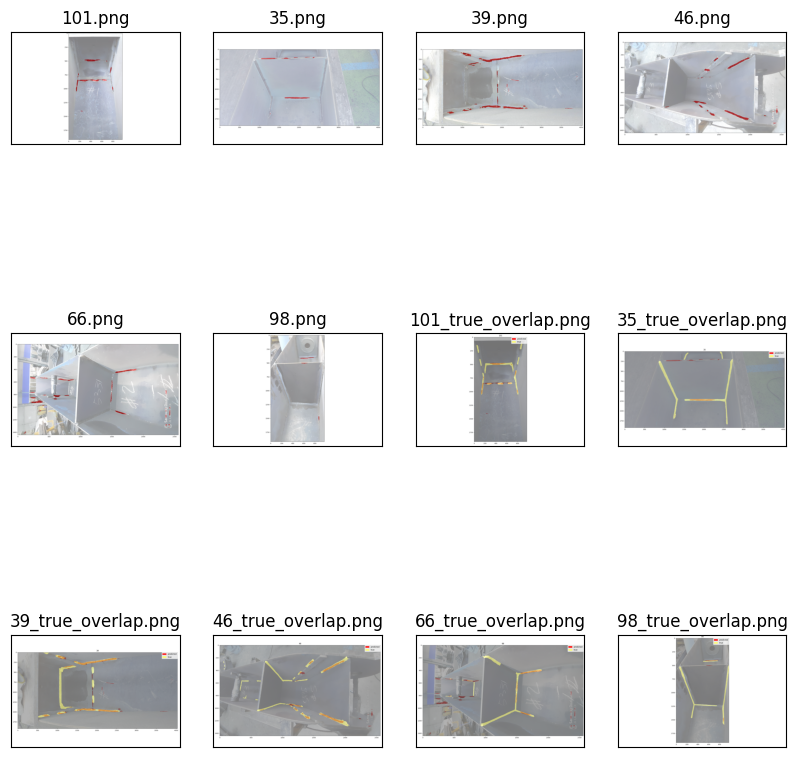

In [6]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import re
import os

def display_images(path='test_image', num_images=10):
    images = []
    names = []
    for img_path in sorted(glob.glob(path + '/*.png'), key=lambda name: ''.join(re.split('/|\.|_', name)[2:4])):
        images.append(mpimg.imread(img_path))
        names.append(os.path.basename(img_path))
    
    show_images = images[0:num_images*2]
    plt.figure(figsize=(10, 15))
    
    columns = 4
    for i, img in enumerate(show_images):
        ax = plt.subplot(int(len(show_images) / columns) + 1, columns, i + 1)
        ax.tick_params(left=False, right=False, labelleft = False, labelbottom=False, bottom=False)
        plt.imshow(img)
        plt.title(names[i])

display_images(num_images=10)